# Variance Gamma Model estimated via Gaussian Process Regression

## What is Gaussian Process Regression (GPR)?

Gaussian process regression (GPR) is a method of interpolation based on Gaussian process governed by prior covariances. 

John Kitchin (2020) provides a simple explaination we will briefly go through: https://kitchingroup.cheme.cmu.edu/f19-06623/23-gp.html

Additional information can be found here:  
Automatic Model Construction with Gaussian Processes - David Duvenaud PhD thesis, https://www.cs.toronto.edu/~duvenaud/thesis.pdf  
Gaussian Processes for Machine Learning - Rasmussen and Williams (2006), http://www.gaussianprocess.org/gpml/chapters/RW.pdf


Notes: Formel für GPR conditional distributions.


## Two simple examples of GPR

We want to use MATLAB as this is what is used in Rasmussen and Williams (2006). As I don't have a licence I use Octave instead which is essentially a open source version of MATLAB. Moreover, we can use Python to execute Octave code for us.

In [61]:
from oct2py import Oct2Py
oc = Oct2Py()

Additionally, we load other packages.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import pandas as pd

### Simple 1 dimensional periodic function

We run code that is an example in the Book Rasmussen and Williams (2006) with some small tweaks from my side to visualize how Gaussian Process Regression learns.

In [63]:
#We need to run the GPML startup script to set up the environment
oc.eval('run("G:/Meine Ablage/Ausbildung/BSc. Wirtschaftsmathematik und Statistik/FVM Seminar/Fast_derivative_pricing_using_Gaussian_Process_Regression/gpml-matlab-master/startup.m")')

executing gpml startup script...


In [64]:
# Prepare data
x = np.random.randn(20, 1) # 20 training inputs
y = np.sin(3 * x) + 0.1 * np.random.randn(20, 1) # 20 noisy training targets
xs = np.linspace(-3, 3, 61).reshape(-1, 1) # 61 test inputs

In [65]:
# Push data to Octave
oc.push('x', x)
oc.push('y', y)
oc.push('xs', xs)

In [66]:
# Run GPR regression in Octave
oc.eval("""
meanfunc = [];
covfunc = @covSEiso;
likfunc = @likGauss;
hyp = struct('mean', [], 'cov', [0 0], 'lik', -1);
hyp2 = minimize(hyp, @gp, -100, @infGaussLik, meanfunc, covfunc, likfunc, x, y);
[mu, s2] = gp(hyp2, @infGaussLik, meanfunc, covfunc, likfunc, x, y, xs);
""")

Function evaluation     54;  Value 2.850568e+00


In [67]:
# Pull results back into Python
mu = oc.pull('mu')
s2 = oc.pull('s2')

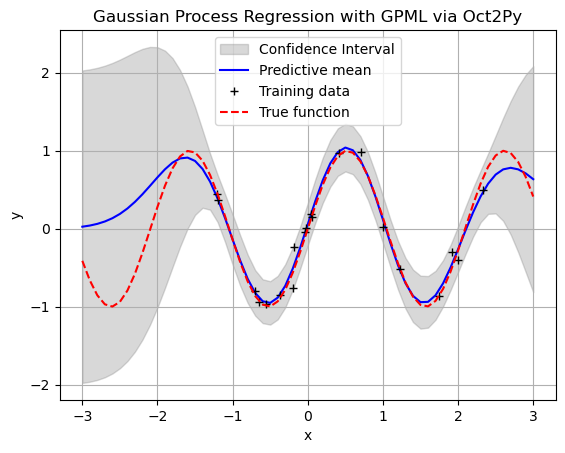

In [68]:
# Plot in Python
f_upper = mu.flatten() + 2 * np.sqrt(s2.flatten())
f_lower = mu.flatten() - 2 * np.sqrt(s2.flatten())

plt.fill_between(xs.flatten(), f_lower, f_upper, color='gray', alpha=0.3, label='Confidence Interval')
plt.plot(xs, mu, 'b-', label='Predictive mean')
plt.plot(x, y, 'k+', label='Training data')
plt.plot(xs, np.sin(3 * xs), 'r--', label='True function')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression with GPML via Oct2Py')
plt.legend()
plt.grid(True)
plt.show()

### Black Scholes Pricing via GPR

We can also use this in a multidimensional case, namely for Black Scholes Option Pricing. Of course we could also use it to compute implied volatility.

In [69]:
# Sample size and parameters
sample_size = 100
S = 100
K = 100
r = 0.05

In [70]:
# Generate data in Python
T = 0.5 + np.random.rand(sample_size, 1)
sigma = 0.15 + 0.1 * np.random.rand(sample_size, 1)

In [71]:
# Black-Scholes formula
d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
y = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [72]:
# Combine inputs
x = np.hstack((T, sigma))

# Push to Octave
oc.push('x', x)
oc.push('y', y)

In [73]:
# GPML regression in Octave 
oc.eval("""
meanfunc = [];
covfunc = @covSEiso;
likfunc = @likGauss;
hyp = struct('mean', [], 'cov', [log(1), log(1)], 'lik', log(0.1));
hyp2 = minimize(hyp, @gp, -500, @infGaussLik, meanfunc, covfunc, likfunc, x, y);
""")

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

Function evaluation     71;  Value -7.671756e+02


Note: "chol: input matrix must be positive definite" means that the Cholesky decomposition inside the GP inference (@infGaussLik) failed because the covariance matrix is not numerically positive definite — which is required for Cholesky. As we use many random data points this can happen but can be ignored.

In [74]:
# Generate test points
T_test = 0.5 + np.random.rand(10, 1)
sigma_test = 0.15 + 0.1 * np.random.rand(10, 1)
x_test = np.hstack((T_test, sigma_test))

In [75]:
# Push and predict
oc.push('x_test', x_test)
oc.eval("[mu_test, ~] = gp(hyp2, @infGaussLik, meanfunc, covfunc, likfunc, x, y, x_test);")
mu_test = oc.pull('mu_test')
print(mu_test)

[[10.7603991 ]
 [13.56234074]
 [ 9.14612967]
 [ 8.79194784]
 [ 9.07089424]
 [13.09797645]
 [ 7.70326051]
 [ 8.59371787]
 [11.02005672]
 [ 7.85395865]]


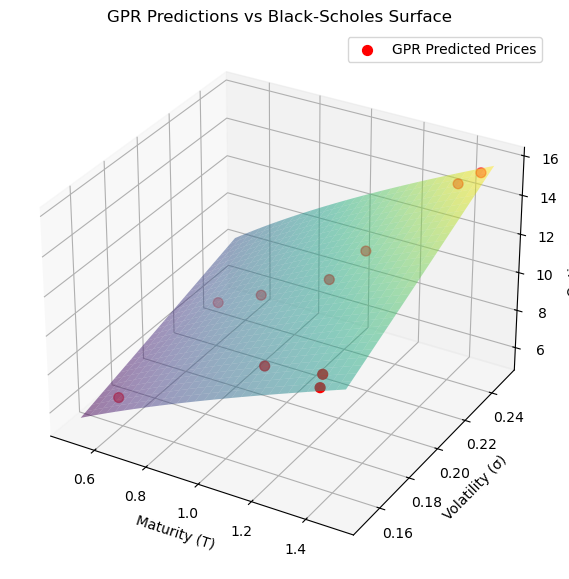

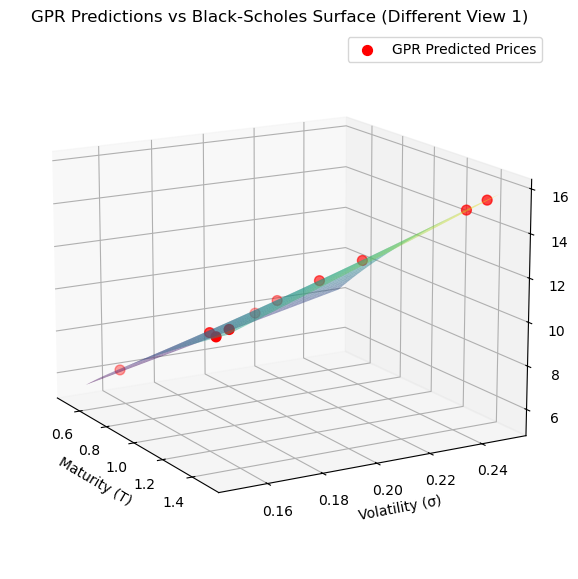

In [16]:
# Create surface grid
T_grid, sigma_grid = np.meshgrid(np.linspace(0.5, 1.5, 30), np.linspace(0.15, 0.25, 30))
S_const = 100
d1_grid = (np.log(S_const / K) + (r + sigma_grid**2 / 2) * T_grid) / (sigma_grid * np.sqrt(T_grid))
d2_grid = d1_grid - sigma_grid * np.sqrt(T_grid)
price_grid = S_const * norm.cdf(d1_grid) - K * np.exp(-r * T_grid) * norm.cdf(d2_grid)

# View 1
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T_test, sigma_test, mu_test, color='r', label='GPR Predicted Prices', s=50)
ax.plot_surface(T_grid, sigma_grid, price_grid, alpha=0.5, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (T)')
ax.set_ylabel('Volatility (σ)')
ax.set_zlabel('Option Price')
ax.set_title('GPR Predictions vs Black-Scholes Surface')
ax.legend()
ax.view_init(elev=30, azim=-60)  # <--- your current angle (approx)
plt.show()

# View 2
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(T_test, sigma_test, mu_test, color='r', label='GPR Predicted Prices', s=50)
ax.plot_surface(T_grid, sigma_grid, price_grid, alpha=0.5, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (T)')
ax.set_ylabel('Volatility (σ)')
ax.set_zlabel('Option Price')
ax.set_title('GPR Predictions vs Black-Scholes Surface (Different View 1)')
ax.legend()
ax.view_init(elev=15, azim=-30)  # <-- first new view
plt.show()


## QuantLib vs. GPR

### QuantLibs pricing engine

We proceed to load QuantLib which is a powerful Quantitative Finance library that can use FFT to solve the pricing of options under the variance gamma model for us. We will then compare with GPR results.  
(???) Does it really use FFT? There is also: FFTVarianceGammaEngine

In [17]:
import QuantLib as ql

We use parameters from an example provided by my main Source for the non-coding part of the presentation - Option Pricing Under the Variance Gamma Process.

In [18]:
# Parameters
T = ql.Date(15, 1, 2016)  # Maturity date
K = 100  # Strike price
r = 0.0514  # Risk-free rate
q = 0.014  # Dividend yield
sigma = 0.20722  # Volatility
theta = -0.22898  # Skewness parameter
nu = 0.50215  # Kurtosis parameter
S = 100  # Current stock price

# We store this as original point
original_point = np.array([T, sigma, theta, nu, S])

In [19]:
# Day count and calendar
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

In [20]:
# Evaluation date
t = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = t

In [21]:
# Option type
option_type = ql.Option.Call

# Payoff and exercise
payoff = ql.PlainVanillaPayoff(option_type, K)
exercise = ql.EuropeanExercise(T)
european_option = ql.VanillaOption(payoff, exercise)

In [22]:
# Market data
spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(t, ql.QuoteHandle(ql.SimpleQuote(r)), day_count)) # we set interest rate constant, in applications one might use a more complex yield structure
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(t, ql.QuoteHandle(ql.SimpleQuote(q)), day_count))

In [23]:
# Set Variance Gamma process
VG_process = ql.VarianceGammaProcess(spot_handle, dividend_yield, flat_ts, sigma, nu, theta)

# Pricing engine
european_option.setPricingEngine(ql.VarianceGammaEngine(VG_process))

In [24]:
# Compute the price and store the computation time
start_time = time.time()

# Repeat the computation 1000 times to get a better average time
for _ in range(1000):
	vg_price = european_option.NPV()  # QuantLib computation

quantlib_time = time.time() - start_time

print("QuantLib c =", vg_price)  # c = 11.218780506712966
print("QuantLib time =", quantlib_time)  # t = 0.001294851303100586

QuantLib c = 11.218780506712966
QuantLib time = 0.00650787353515625


### GPR based pricing

#### Generate Training Data

First we need a training set around the evaluation point where we use QuantLib to compute the price at these points. Then we will use GPR to price the option we priced earlier.

In [43]:
# Define ranges for parameters with random components around the original point
T_range = [original_point[0] + ql.Period(i, ql.Days) for i in range(-4, 4, 1)]
sigma_range = np.linspace(original_point[1] - 0.1, original_point[1] + 0.1, 5)
theta_range = np.linspace(original_point[2] - 0.1, original_point[2] + 0.1, 5)
nu_range = np.linspace(original_point[3] - 0.2, original_point[3] + 0.2, 5)
S_range = np.linspace(original_point[4] - 20, original_point[4] + 20, 5)

# Table of ranges and observations
print("\nTable of Ranges and Observations:")
print(f"{'Parameter':<15}{'Range':<45}{'Observations':<15}")
print(f"{'-'*75}")
print(f"{'T_range':<15}{f'{T_range[0]} to {T_range[-1]}':<45}{len(T_range):<15}")
print(f"{'sigma_range':<15}{f'{round(sigma_range[0], 3)} to {round(sigma_range[-1], 3)}':<45}{len(sigma_range):<15}")
print(f"{'theta_range':<15}{f'{round(theta_range[0], 3)} to {round(theta_range[-1], 3)}':<45}{len(theta_range):<15}")
print(f"{'nu_range':<15}{f'{round(nu_range[0], 3)} to {round(nu_range[-1], 3)}':<45}{len(nu_range):<15}")
print(f"{'S_range':<15}{f'{S_range[0]} to {S_range[-1]}':<45}{len(S_range):<15}")




Table of Ranges and Observations:
Parameter      Range                                        Observations   
---------------------------------------------------------------------------
T_range        January 11th, 2016 to January 18th, 2016     8              
sigma_range    0.107 to 0.307                               5              
theta_range    -0.329 to -0.129                             5              
nu_range       0.302 to 0.702                               5              
S_range        80.0 to 120.0                                5              


In [46]:
import itertools

# Create a grid of all combinations
parameter_grid = list(itertools.product(T_range, sigma_range, theta_range, nu_range, S_range))

# Define epsilon for minimum Euclidean distance
epsilon = 0.1

# Filter the parameter grid to exclude points where sigma, theta, and nu are within the epsilon radius
filtered_parameter_grid = [
    params for params in parameter_grid
    if np.linalg.norm(np.array([params[1], params[2], params[3]]) - np.array([original_point[1], original_point[2], original_point[3]])) > epsilon
]

# Convert back to numpy array for further processing
filtered_parameter_grid = np.array(filtered_parameter_grid)

# Debugging: Print the number of points before and after filtering
print("Total points before filtering: ", len(parameter_grid))
print("Total points after filtering: ", len(filtered_parameter_grid))

Total points before filtering:  5000
Total points after filtering:  4400


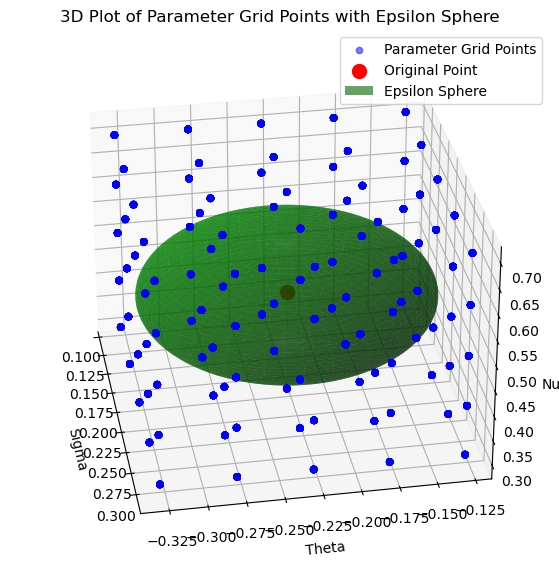

In [47]:
# Extract sigma, theta, and nu from the parameter grid
sigma = np.array([params[1] for params in filtered_parameter_grid])
theta = np.array([params[2] for params in filtered_parameter_grid])
nu = np.array([params[3] for params in filtered_parameter_grid])


# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the parameter grid points
ax.scatter(sigma, theta, nu, color='blue', alpha=0.5, label='Parameter Grid Points')

# Plot the original point
ax.scatter(original_point[1], original_point[2], original_point[3], color='red', s=100, label='Original Point')

# Create a sphere around the original point
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = epsilon * np.outer(np.cos(u), np.sin(v)) + original_point[1]
y = epsilon * np.outer(np.sin(u), np.sin(v)) + original_point[2]
z = epsilon * np.outer(np.ones(np.size(u)), np.cos(v)) + original_point[3]
ax.plot_surface(x, y, z, color='green', alpha=0.6, label='Epsilon Sphere')

# Set labels and title
ax.set_xlabel('Sigma')
ax.set_ylabel('Theta')
ax.set_zlabel('Nu')
ax.set_title('3D Plot of Parameter Grid Points with Epsilon Sphere')

ax.view_init(elev=30, azim=-10)

# Add legend
ax.legend()

# Show the plot
plt.show()

In [48]:
# Initialize an empty list to store results
prices = []

# Iterate through the filtered parameter grid
for params in filtered_parameter_grid:
    T, sigma, theta, nu, S = params  # Unpack the parameters
    
    # Update the evaluation date and maturity
    exercise = ql.EuropeanExercise(T)
    european_option = ql.VanillaOption(payoff, exercise)
    
    # Update the market data
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(t, ql.QuoteHandle(ql.SimpleQuote(r)), day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(t, ql.QuoteHandle(ql.SimpleQuote(q)), day_count))
    
    # Update the Variance Gamma process
    VG_process = ql.VarianceGammaProcess(spot_handle, dividend_yield, flat_ts, sigma, nu, theta)
    
    # Set the pricing engine
    european_option.setPricingEngine(ql.VarianceGammaEngine(VG_process))
    
    # Compute the price
    price = european_option.NPV()
    prices.append([T, sigma, theta, nu, S, price])  # Store each parameter and the price as separate columns

# Convert results to a DataFrame with separate columns
import pandas as pd
results_df = pd.DataFrame(prices, columns=["T", "Sigma", "Theta", "Nu", "S", "Price"])

# Display the first few results
print(results_df.sample(5))

                       T    Sigma    Theta       Nu      S      Price
1049  January 12th, 2016  0.30722 -0.22898  0.70215  120.0  29.207233
414   January 11th, 2016  0.25722 -0.12898  0.40215  120.0  26.688991
2275  January 15th, 2016  0.10722 -0.17898  0.40215   80.0   0.164778
1007  January 12th, 2016  0.30722 -0.27898  0.30215  100.0  14.113972
3568  January 17th, 2016  0.20722 -0.27898  0.70215  110.0  19.901519


#### Learn function and price our original parameters

In [49]:
# Convert QuantLib.Date objects in T to numeric values
reference_date = ql.Date(1, 1, 1970)  # Example reference date
T_numeric = np.array([(t - reference_date) for t in results_df["T"]])  # Convert to days

# Combine all 5 parameters (T, Sigma, Theta, Nu, S) into x
x = np.hstack((
    T_numeric.reshape(-1, 1),  # Numeric T
    results_df["Sigma"].values.reshape(-1, 1),
    results_df["Theta"].values.reshape(-1, 1),
    results_df["Nu"].values.reshape(-1, 1),
    results_df["S"].values.reshape(-1, 1)
))

# Use the computed prices as the target variable
y = results_df["Price"].values.reshape(-1, 1)

In [52]:
# Verify x and y
print("x shape:", x.shape)
print("x contents:\n", x)
print("y shape:", y.shape)
print("y contents:\n", y)

x shape: (4400, 5)
x contents:
 [[ 1.6811e+04  1.0722e-01 -3.2898e-01  3.0215e-01  8.0000e+01]
 [ 1.6811e+04  1.0722e-01 -3.2898e-01  3.0215e-01  9.0000e+01]
 [ 1.6811e+04  1.0722e-01 -3.2898e-01  3.0215e-01  1.0000e+02]
 ...
 [ 1.6818e+04  3.0722e-01 -1.2898e-01  7.0215e-01  1.0000e+02]
 [ 1.6818e+04  3.0722e-01 -1.2898e-01  7.0215e-01  1.1000e+02]
 [ 1.6818e+04  3.0722e-01 -1.2898e-01  7.0215e-01  1.2000e+02]]
y shape: (4400, 1)
y contents:
 [[ 0.74746627]
 [ 3.92979591]
 [ 9.62040377]
 ...
 [13.12813454]
 [20.22445625]
 [28.23245976]]


In [53]:
# Push data to Octave
oc.push('x', x)
oc.push('y', y)

In [54]:
# GPML regression in Octave
oc.eval("""
meanfunc = [];
covfunc = @covSEiso;
likfunc = @likGauss;
hyp = struct('mean', [], 'cov', [log(1), log(1)], 'lik', log(0.1));
hyp2 = minimize(hyp, @gp, -500, @infGaussLik, meanfunc, covfunc, likfunc, x, y);
""")

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize at line 99 column 19
    _pyeval at line 48 column 11

    gp at line 144 column 5
    minimize

In [ ]:
# Convert QuantLib.Date to numeric representation (e.g., days since reference_date)
T_numeric = (original_point[0] - reference_date)  # Convert to days

# Prepare the original point as a test input
x_test = np.array([[T_numeric, original_point[1], original_point[2], original_point[3], original_point[4]]])  # T_numeric pf the original point
print(x_test)

oc.push('x_test', x_test)

[[ 1.6815e+04  2.0722e-01 -2.2898e-01  5.0215e-01  1.0000e+02]]


In [81]:
# Predict the price for the original point
start_time = time.time()
for i in range(10):
    oc.eval("[vg_price_gpr, ~] = gp(hyp2, @infGaussLik, meanfunc, covfunc, likfunc, x, y, x_test);")
    #oc.eval("vg_price_gpr = gp(hyp2, @infGaussLik, meanfunc, covfunc, likfunc, x, y, x_test);")
gpr_time = 100*(time.time() - start_time)
vg_price_gpr = oc.pull('vg_price_gpr')

### Compare the results (Accuracy and Speed)

In [76]:
#Display the predicted price
print("Predicted price for the original parameters using GPR:", vg_price_gpr)
print("QuantLib c =", vg_price) # c = 11.218780506712966
print("Difference between QuantLib and GPR prediction:", np.abs(vg_price - vg_price_gpr))

Predicted price for the original parameters using GPR: 11.216453552246094
QuantLib c = 11.218780506712966
Difference between QuantLib and GPR prediction: 0.002326954466871811


In [77]:
# Display the computation times and predicted price
print("Computation time for GPR (scaled to 1000 iterations):", gpr_time, "ms") # 3330.928945541382 ms
print("Computation time for QuantLib (1000 iterations):", quantlib_time, "ms") # 0.0010037422180175781 ms
print("Difference between QuantLib and GPR prediction:", np.abs(vg_price - vg_price_gpr)) # 4.87702317641947e-07

# Calculate the time difference and determine the faster method
time_difference = quantlib_time - gpr_time
if time_difference > 0:
    relative_speed = quantlib_time / gpr_time
    print("GPR was faster by", round(time_difference, 2), "ms.")
    print("GPR was approximately", round(relative_speed, 2), "times faster than QuantLib.")
else:
    relative_speed = gpr_time / quantlib_time
    print("QuantLib was faster by", round(abs(time_difference), 2), "ms.")  # 3330.93 ms
    print("QuantLib was approximately", round(relative_speed, 2), "times faster than GPR.")  # 3318510.36 times faster


Computation time for GPR (scaled to 1000 iterations): 3033.9428424835205 ms
Computation time for QuantLib (1000 iterations): 0.00650787353515625 ms
Difference between QuantLib and GPR prediction: 0.002326954466871811
QuantLib was faster by 3033.94 ms.
QuantLib was approximately 466195.73 times faster than GPR.


The accuracy is promising and aligns with the findings of Spiegler et al. (2018), who reported an error of 3.277e-04. However, the computation time is disappointing. I am not enough of a MATLab-pro to change the `gp` function, but as I understand it it unnecessarily inverts matrices to compute the covariance of the estimation (Recall the conditional distribution of f_* under training inputs, training outputs and test inputs), even though this step is not relevant in this context. In the study by Spiegler et al. (2018), a 30x speed-up over FFT was achieved, highlighting the potential for optimization.